In [1]:
import openmm as mm
from openmm import unit
from openmm import app
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyunitwizard as puw
import networkx as nx

In [2]:
pdb = app.PDBFile('barnase_barstar.pdb')
original_positions = pdb.getPositions(asNumpy=True)

In [3]:
num_total_atomos = original_positions.shape[0]



In [4]:
list_chains = list(pdb.topology.chains())
print(f'Tenemos {len(list_chains)} cadenas de átomos en ek pdb')

Tenemos 2 cadenas de átomos en ek pdb


In [5]:
num_atomos_cadena_1 = len(list(list_chains[0].atoms()))
num_atomos_cadena_2 = len(list(list_chains[1].atoms()))

print(f'En la cadena 1 tenemos {num_atomos_cadena_1} átomos')
print(f'En la cadena 2 tenemos {num_atomos_cadena_2} átomos')

En la cadena 1 tenemos 1727 átomos
En la cadena 2 tenemos 1432 átomos


In [6]:
indices_1 = list(range(0,num_atomos_cadena_1)) # Indices of molecule 1
indices_2 = list(range(num_atomos_cadena_1,num_total_atomos)) # Indices of molecule 2


In [7]:
original_positions_1=original_positions[indices_1]
original_positions_2=original_positions[indices_2]

In [8]:
centro_1 = np.mean(original_positions_1, 0)
centro_2 = np.mean(original_positions_2, 0)

In [9]:
original_positions_1=original_positions[indices_1]
original_positions_2=original_positions[indices_2]

In [10]:
r=centro_2-centro_1
original_dist_centros = np.linalg.norm(r)
original_dist_centros

2.3962948699429214

In [11]:
original_dist_centros = original_dist_centros * r.unit


In [12]:
original_dist_centros

Quantity(value=2.3962948699429214, unit=nanometer)

In [13]:
vec_normalizado=r/original_dist_centros


In [14]:
vec_normalizado

array([ 0.03898872, -0.46648492,  0.88366945])

In [15]:
forcefield = app.ForceField('amber14-all.xml')

system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

step_size   = 0.002*unit.picoseconds
temperature = 0.0*unit.kelvin
friction    = 0.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name = 'CPU'
platform    = mm.Platform.getPlatformByName(platform_name)

context = mm.Context(system, integrator, platform)

In [16]:

context.setPositions(original_positions)
state = context.getState(getEnergy=True)
state.getPotentialEnergy()

Quantity(value=15294.695710703032, unit=kilojoule/mole)

In [17]:
distancias_entre_centros = []
energias_potenciales = []

In [18]:
N = 1000
delta_x = 0.025 * unit.nanometers

In [19]:

for ii in tqdm(range(N)):
    temporal_position_2 = original_positions_2 + ii*delta_x*vec_normalizado
    new_positions = original_positions
    new_positions[indices_2,:] = temporal_position_2[:,:] # Actualizo las coordenadas de la molécula 2
    context.setPositions(new_positions)
    state = context.getState(getEnergy=True)
    energia_potencial= state.getPotentialEnergy() # Calculo la energía potencial
    # Guardo los valores
    distancias_entre_centros.append(original_dist_centros+ii*delta_x)
    energias_potenciales.append(energia_potencial)

100%|███████████████████████████████████████| 1000/1000 [01:53<00:00,  8.84it/s]


In [23]:
energias_potenciales = puw.concatenate(energias_potenciales)
distancias_entre_centros = puw.concatenate(distancias_entre_centros)


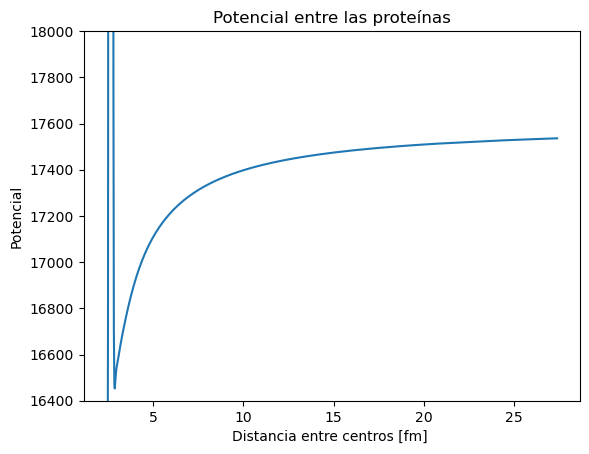

In [24]:
plt.plot(distancias_entre_centros ,energias_potenciales)
plt.ylim(16400,18000)
plt.xlabel('Distancia entre centros [fm] ')
plt.ylabel('Potencial')
plt.title('Potencial entre las proteínas')
plt.show()

In [253]:
#vamos a construir un espacio cúbico 
#este es un ejemplo para una partición del cubo que mide 
#definimos la cantidad de puntos en una dirección de la grid 
#que medirá diez nanómetros
tam = 5
a = np.linspace(-5,5,tam,True) 
#creamos listas vacías para llenarlas con los puntos de la grid
i = []
j = []
coord = []
#llenamos la grid con los puntos
for n in range(tam):
    for l in range(tam):
        for m in range(tam):
            coord.append([a[n],a[l],a[m]]*r.unit)
tt=10/(tam-1)

In [254]:
#ahora metemos todo en un ciclo para calcular 
#la energía potencial en cada punto
#creamos un vector para las coordenadas actualizadas
coordenadas_nuevas = []
energias_potenciales = []
for ii in tqdm(range(len(coord))):
    #no se necesita normalizar el vector dirección ahora sólo sumamos las coordenadas
    #de los vectores de posición a la posición de las otras partículas
    
    
    temporal_position_2 = original_positions_2 + coord[ii]
    new_positions = original_positions
    new_positions[indices_2,:] = temporal_position_2[:,:] # Actualizo las coordenadas de la molécula 2
    context.setPositions(new_positions)
    state = context.getState(getEnergy=True)
    energia_potencial= state.getPotentialEnergy() # Calculo la energía potencial
    # Guardo los valores
    coordenadas_nuevas.append(original_positions + coord[ii])
    energias_potenciales.append(energia_potencial)


100%|█████████████████████████████████████████| 125/125 [00:14<00:00,  8.90it/s]


In [255]:
#creo una lista vacía para pasar sólo los valores sin unidades del la lista de energía potencial
cddd=[]
for ii in range(len(energias_potenciales)):
                cddd.append(puw.get_value(energias_potenciales[ii]))
#creo otra lista que solo tenga las coordenadas
cdena=[]
for ii in range(len(coord)):
                cdena.append(puw.get_value(coord[ii]))
np.array(cdena)

array([[-5. , -5. , -5. ],
       [-5. , -5. , -2.5],
       [-5. , -5. ,  0. ],
       [-5. , -5. ,  2.5],
       [-5. , -5. ,  5. ],
       [-5. , -2.5, -5. ],
       [-5. , -2.5, -2.5],
       [-5. , -2.5,  0. ],
       [-5. , -2.5,  2.5],
       [-5. , -2.5,  5. ],
       [-5. ,  0. , -5. ],
       [-5. ,  0. , -2.5],
       [-5. ,  0. ,  0. ],
       [-5. ,  0. ,  2.5],
       [-5. ,  0. ,  5. ],
       [-5. ,  2.5, -5. ],
       [-5. ,  2.5, -2.5],
       [-5. ,  2.5,  0. ],
       [-5. ,  2.5,  2.5],
       [-5. ,  2.5,  5. ],
       [-5. ,  5. , -5. ],
       [-5. ,  5. , -2.5],
       [-5. ,  5. ,  0. ],
       [-5. ,  5. ,  2.5],
       [-5. ,  5. ,  5. ],
       [-2.5, -5. , -5. ],
       [-2.5, -5. , -2.5],
       [-2.5, -5. ,  0. ],
       [-2.5, -5. ,  2.5],
       [-2.5, -5. ,  5. ],
       [-2.5, -2.5, -5. ],
       [-2.5, -2.5, -2.5],
       [-2.5, -2.5,  0. ],
       [-2.5, -2.5,  2.5],
       [-2.5, -2.5,  5. ],
       [-2.5,  0. , -5. ],
       [-2.5,  0. , -2.5],
 

In [256]:
#iniciamos un grafo
G=nx.Graph()

In [257]:
#Defino como primeros vecinos a aquellos vectores cuya norma de la diferencia es exactamente tt
def vecino(aa=[],bb=[]):
    res=np.linalg.norm(aa-bb)
    return res

In [258]:
#agregamos los nodos desde la lista
G.add_nodes_from(cddd)
#asocio a cada energía sus coordenadas
comb=list(zip(cddd,np.array(cdena)))

#para crear las relaciones para primeros vecinos defino la norma ecuclidiana entre vectores posición podemos acceder al 
#valor del potencial con la primera entrada igual a 0 y al valor de las coordenadas con la segunda entrada igual a 1
#hago un ciclo para que haga las relaciones a primeros vecinos
for ii in range(len(comb)):
    for jj in range(len(comb)):
                    if vecino(comb[ii][1],comb[jj][1])==tt:
                        G.add_edge(cddd[ii],cddd[jj])

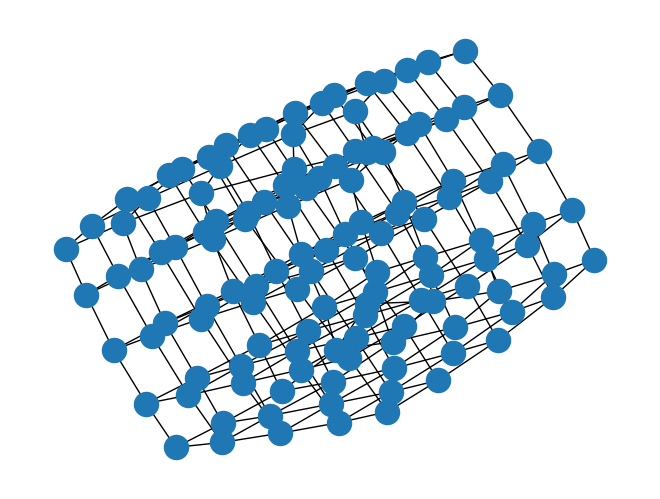

In [268]:
nx.draw(G)